# Sequence to Sequence Modelling

**Note**: All code should be in Python3. Keras version should be 2.0.4. The directory structure on the bitbucket repo should be exactly same as the hw4.zip provided to you (with the exception of data directory. Do not upload it). To push the code to remote repo, use the same instructions as given in HW0. **Double check you remote repo for correct directory structure. We won't consider any regrade requests based on wrong directory structure penalty. Again, do not upload data to your bitbucket repo ** <br>
**The data provided to you should not be used for any other purpose than this course. You must not distribute it or upload it to any public platform.**

![title](seq2seq.png)

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

Name: Jun Guo

Uni: jg3555

Email: jg3555@columbia.edu

# Preparing Inputs

The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [1]:
MAX_LEN = 200
VOCAB_SIZE = 12000

Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [2]:
# TO-DO
import numpy as np
from os import listdir
import random
import pickle
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D, Input, RepeatVector
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard
#from keras import initializers
from keras import backend as K
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras import optimizers
from multiprocessing import Pool, set_start_method
import tensorflow as tf
import time as time
from rouge import Rouge 
import os, re

Using TensorFlow backend.


In [3]:
def load_data(article, summary, max_len, vocab_size, reverse = False):
    transformed_article, vocab_size_article, idx2word_article, word2idx_article\
    = transform_data(article, max_len, vocab_size, reverse= reverse, adjust_length = True)
    
    transformed_summary, vocab_size_summary, idx2word_summary, word2idx_summary\
    = transform_data(summary, max_len, vocab_size, reverse= reverse, adjust_length = True)
    
    return transformed_article, vocab_size_article, idx2word_article, word2idx_article, \
           transformed_summary, vocab_size_summary, idx2word_summary, word2idx_summary
#complete this function using details as above


def read_txt(filename):
    directory = './data/'
    output = []
    with open(directory+filename+'.txt','r', ) as file:
        for line in file:
            str_ = " ".join(line.split(' '))
            output.append(str_)
    file.close()

    return output

def transform_data(texts, max_len, vocab_size, reverse = False, adjust_length= False):
    _text_vocab_size = vocab_size * len(texts)
    tokenizer = Tokenizer(num_words= _text_vocab_size)
    tokenizer.fit_on_texts(texts)
    try:
        tokenizer.word_index['ZERO']
    except KeyError:
        tokenizer.word_index['ZERO'] = 0
        vocab_size += 1

    try:
        unk = tokenizer.word_index['unk']
    except KeyError:
        tokenizer.word_index['unk'] = vocab_size
        unk = vocab_size
        vocab_size += 1
    
    idx2word  = np.empty(vocab_size).astype(str)
    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:
            idx2word[idx] = word

    word2idx_temp = tokenizer.texts_to_sequences(texts)
    word2idx = [[unk if idx > vocab_size  else idx for idx in line] for line in word2idx_temp]
    if reverse == True:
        word2idx = [[i for i in reversed(line)]for line in word2idx]
    
    #Omit outliers
    if  adjust_length == True:
        len_list = [len(line) for line in word2idx]
        max_len = int(np.mean(len_list) + 3 * np.std(len_list))

    transformed_data = sequence.pad_sequences(word2idx, maxlen= max_len, padding= 'post')
    
    return transformed_data, vocab_size, idx2word[:vocab_size + 1], word2idx


In [4]:
def test_transform(text, idx2word, max_len):

    wsq = [text_to_word_sequence(line) for line in text]
    i2w_dict = {}
    for idx, word in enumerate(idx2word):
        i2w_dict[word] = idx 
    
    unk = i2w_dict['unk']
    text_w2i = []
    for line in wsq:
        seq_line = []
        for word in line:
            try:
                seq_line.append(i2w_dict[word])
            except KeyError:
                seq_line.append(unk)
        text_w2i.append(seq_line)
    
    transformed_data = sequence.pad_sequences(text_w2i, maxlen= max_len, padding= 'post')
    
    return transformed_data

Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [5]:
filenames = ['test_article','test_title','train_article','train_title']
test_article, test_title, train_article, train_title = list(read_txt(filename) for filename in filenames)

tr_x, vocab_size_tr_x, i2w_tr_x, w2i_tr_x, tr_y, vocab_size_tr_y, i2w_tr_y, w2i_tr_y =\
load_data(train_article, train_title, MAX_LEN, VOCAB_SIZE)

ts_x = test_transform(test_article, i2w_tr_x, tr_x.shape[1])
ts_y = test_transform(test_title, i2w_tr_y, tr_y.shape[1])

In [6]:
def onehot_encoder(matrix, num_classes):
    result = (np.arange(num_classes) == matrix[...,None]).astype(np.int32)
    return result

def onehot_decoder(predict_y):
    return np.array(list(np.argmax(row, axis = 1) for row in predict_y))


# Unidirectional LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [7]:
NUM_LAYERS = 1
HIDDEN_DIM = 500
EPOCHS = 50
count_batches = 100
BATCH_SIZE = int(len(tr_y)/count_batches)

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [10]:
def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    # define model
    model = Sequential()
    model.add(Embedding(X_vocab_len, output_dim = hidden_size, input_length= X_max_len, mask_zero= True)) #, weights = [g_word_embedding_matrix]
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))
    for _ in range(num_layers):
        model.add(LSTM(hidden_size, return_sequences=True))
    
    model.add(LSTM(hidden_size, return_sequences=True))
    model.add(TimeDistributed(Dense(y_vocab_len, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    model.summary()
    
    return model

# Train the Model

In [53]:
model = create_UniLSTM(vocab_size_tr_x, tr_x.shape[1], vocab_size_tr_y, tr_y.shape[1], HIDDEN_DIM, NUM_LAYERS)

'''full sample'''
indices = np.arange(int(9/10*len(tr_x))) # 9/10 as Training 1/10 as Validation
batch_size = int(9 /10 * len(tr_y)/count_batches)

for EPOCH in range(EPOCHS):
    np.random.shuffle(indices)
    x = tr_x[indices]
    y = tr_y[indices]
    init = time.time()
    for j in range(int(count_batches)): 
        beg = j* batch_size
        end = (j+1)* batch_size
        ohv_y =  onehot_encoder(y[beg : end], vocab_size_tr_y)
#         if EPOCH == 0:
#             model.load_weights('checkpoint_h1_12k500_epoch_51.hdf5')

        print('[INFO] Training model: epoch %s th %s/%s samples' %(EPOCH + 1, j+1, count_batches))
        model.fit(x[beg : end], ohv_y, epochs= 1, verbose=1, batch_size= batch_size)
        
    print('[INFO] Time actually taken is %s3 s' %(time.time()-init))
    if EPOCH%5 == 0:
        print('Save_Weight')
        model.save_weights('checkpoint_h1_12k500_epoch_'+str(EPOCH + 1)+'.hdf5')

model.save_weights('checkpoint_h1_12k500_epoch_'+str(EPOCH + 1)+'.hdf5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 19, 500)           6000500   
_________________________________________________________________
lstm_14 (LSTM)               (None, 500)               2002000   
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 14, 500)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 14, 500)           2002000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 14, 500)           2002000   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 14, 12001)         6012501   
Total params: 18,019,001
Trainable params: 18,019,001
Non-trainable params: 0
________________________________________________________________

450/450 [==============================] - 1s 2ms/step - loss: 4.0989 - acc: 0.5056
[INFO] Training model: epoch 1 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.2664 - acc: 0.4895
[INFO] Training model: epoch 1 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.2610 - acc: 0.4962
[INFO] Training model: epoch 1 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.4511 - acc: 0.4881
[INFO] Training model: epoch 1 th 54/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.2098 - acc: 0.4868
[INFO] Training model: epoch 1 th 55/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1791 - acc: 0.4949
[INFO] Training model: epoch 1 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.2000 - acc: 0.4935
[INFO] Training model: epoch 1 th 57/100 samples
Epoch 1/1

450/450 [==============================] - 1s 2ms/step - loss: 4.2237 - acc: 0.4829
[INFO] Training model: epoch 2 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1123 - acc: 0.4952
[INFO] Training model: epoch 2 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9937 - acc: 0.5144
[INFO] Training model: epoch 2 th 10/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1900 - acc: 0.4816
[INFO] Training model: epoch 2 th 11/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1032 - acc: 0.4962
[INFO] Training model: epoch 2 th 12/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1056 - acc: 0.4959
[INFO] Training model: epoch 2 th 13/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1687 - acc: 0.4890
[INFO] Training model: epoch 2 th 14/100 samples
Epoch 1/1
4

[INFO] Training model: epoch 2 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.0981 - acc: 0.4919
[INFO] Training model: epoch 2 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1213 - acc: 0.4913
[INFO] Training model: epoch 2 th 67/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1414 - acc: 0.4938
[INFO] Training model: epoch 2 th 68/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.1164 - acc: 0.4905
[INFO] Training model: epoch 2 th 69/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.0616 - acc: 0.4943
[INFO] Training model: epoch 2 th 70/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.0681 - acc: 0.4997
[INFO] Training model: epoch 2 th 71/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 4.0830 - acc: 0.4919

[INFO] Training model: epoch 3 th 22/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9085 - acc: 0.5076
[INFO] Training model: epoch 3 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9545 - acc: 0.5095
[INFO] Training model: epoch 3 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8962 - acc: 0.5049
[INFO] Training model: epoch 3 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8965 - acc: 0.5060
[INFO] Training model: epoch 3 th 26/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8988 - acc: 0.5059
[INFO] Training model: epoch 3 th 27/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9255 - acc: 0.5052
[INFO] Training model: epoch 3 th 28/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9029 - acc: 0.5029

450/450 [==============================] - 1s 2ms/step - loss: 3.9787 - acc: 0.4998
[INFO] Training model: epoch 3 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9826 - acc: 0.4957
[INFO] Training model: epoch 3 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8891 - acc: 0.5070
[INFO] Training model: epoch 3 th 82/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7819 - acc: 0.5181
[INFO] Training model: epoch 3 th 83/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9947 - acc: 0.4983
[INFO] Training model: epoch 3 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8695 - acc: 0.5090
[INFO] Training model: epoch 3 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9862 - acc: 0.4968
[INFO] Training model: epoch 3 th 86/100 samples
Epoch 1/1

450/450 [==============================] - 1s 2ms/step - loss: 3.9000 - acc: 0.4998
[INFO] Training model: epoch 4 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9138 - acc: 0.4970
[INFO] Training model: epoch 4 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9548 - acc: 0.4954
[INFO] Training model: epoch 4 th 39/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9438 - acc: 0.4924
[INFO] Training model: epoch 4 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8976 - acc: 0.5014
[INFO] Training model: epoch 4 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9129 - acc: 0.4984
[INFO] Training model: epoch 4 th 42/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8987 - acc: 0.4975
[INFO] Training model: epoch 4 th 43/100 samples
Epoch 1/1

[INFO] Training model: epoch 4 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7532 - acc: 0.5219
[INFO] Training model: epoch 4 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9832 - acc: 0.4929
[INFO] Training model: epoch 4 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9204 - acc: 0.4992
[INFO] Training model: epoch 4 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7969 - acc: 0.5087
[INFO] Training model: epoch 4 th 98/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9437 - acc: 0.5024
[INFO] Training model: epoch 4 th 99/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8232 - acc: 0.5125
[INFO] Training model: epoch 4 th 100/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9905 - acc: 0.491

[INFO] Training model: epoch 5 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8058 - acc: 0.5084
[INFO] Training model: epoch 5 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8437 - acc: 0.4956
[INFO] Training model: epoch 5 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9875 - acc: 0.4886
[INFO] Training model: epoch 5 th 54/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8435 - acc: 0.4997
[INFO] Training model: epoch 5 th 55/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7681 - acc: 0.5081
[INFO] Training model: epoch 5 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8914 - acc: 0.4954
[INFO] Training model: epoch 5 th 57/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8032 - acc: 0.5062

[INFO] Training model: epoch 6 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8093 - acc: 0.4956
[INFO] Training model: epoch 6 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7503 - acc: 0.5062
[INFO] Training model: epoch 6 th 10/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9384 - acc: 0.4862
[INFO] Training model: epoch 6 th 11/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7847 - acc: 0.5040
[INFO] Training model: epoch 6 th 12/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.9201 - acc: 0.4921
[INFO] Training model: epoch 6 th 13/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7771 - acc: 0.5035
[INFO] Training model: epoch 6 th 14/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8646 - acc: 0.4881
[

450/450 [==============================] - 1s 2ms/step - loss: 3.6793 - acc: 0.5192
[INFO] Training model: epoch 6 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7113 - acc: 0.5119
[INFO] Training model: epoch 6 th 67/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7952 - acc: 0.4962
[INFO] Training model: epoch 6 th 68/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7053 - acc: 0.5106
[INFO] Training model: epoch 6 th 69/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7915 - acc: 0.5024
[INFO] Training model: epoch 6 th 70/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6934 - acc: 0.5144
[INFO] Training model: epoch 6 th 71/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7035 - acc: 0.5130
[INFO] Training model: epoch 6 th 72/100 samples
Epoch 1/1

450/450 [==============================] - 1s 2ms/step - loss: 3.7649 - acc: 0.5044
[INFO] Training model: epoch 7 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6836 - acc: 0.5097
[INFO] Training model: epoch 7 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6649 - acc: 0.5021
[INFO] Training model: epoch 7 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.8072 - acc: 0.4967
[INFO] Training model: epoch 7 th 26/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5982 - acc: 0.5237
[INFO] Training model: epoch 7 th 27/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7604 - acc: 0.5024
[INFO] Training model: epoch 7 th 28/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6996 - acc: 0.5130
[INFO] Training model: epoch 7 th 29/100 samples
Epoch 1/1

[INFO] Training model: epoch 7 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7868 - acc: 0.4957
[INFO] Training model: epoch 7 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7438 - acc: 0.5052
[INFO] Training model: epoch 7 th 82/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6767 - acc: 0.5097
[INFO] Training model: epoch 7 th 83/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7030 - acc: 0.5127
[INFO] Training model: epoch 7 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6231 - acc: 0.5176
[INFO] Training model: epoch 7 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7816 - acc: 0.4924
[INFO] Training model: epoch 7 th 86/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5888 - acc: 0.5195

[INFO] Training model: epoch 8 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7314 - acc: 0.5017
[INFO] Training model: epoch 8 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6590 - acc: 0.5108
[INFO] Training model: epoch 8 th 39/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5673 - acc: 0.5200
[INFO] Training model: epoch 8 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6050 - acc: 0.5148
[INFO] Training model: epoch 8 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5956 - acc: 0.5140
[INFO] Training model: epoch 8 th 42/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6592 - acc: 0.5054
[INFO] Training model: epoch 8 th 43/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6478 - acc: 0.5027

450/450 [==============================] - 1s 2ms/step - loss: 3.4811 - acc: 0.5397
[INFO] Training model: epoch 8 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6253 - acc: 0.5208
[INFO] Training model: epoch 8 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6372 - acc: 0.5105
[INFO] Training model: epoch 8 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.7660 - acc: 0.4954
[INFO] Training model: epoch 8 th 98/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5453 - acc: 0.5238
[INFO] Training model: epoch 8 th 99/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4652 - acc: 0.5281
[INFO] Training model: epoch 8 th 100/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6812 - acc: 0.5030
[INFO] Time actually taken is 123.130089521408083 s
[INFO

450/450 [==============================] - 1s 2ms/step - loss: 3.6814 - acc: 0.5017
[INFO] Training model: epoch 9 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4987 - acc: 0.5270
[INFO] Training model: epoch 9 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5858 - acc: 0.5081
[INFO] Training model: epoch 9 th 54/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6590 - acc: 0.5111
[INFO] Training model: epoch 9 th 55/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4938 - acc: 0.5252
[INFO] Training model: epoch 9 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.6064 - acc: 0.5114
[INFO] Training model: epoch 9 th 57/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4507 - acc: 0.5294
[INFO] Training model: epoch 9 th 58/100 samples
Epoch 1/1

450/450 [==============================] - 1s 2ms/step - loss: 3.4128 - acc: 0.5222
[INFO] Training model: epoch 10 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4618 - acc: 0.5176
[INFO] Training model: epoch 10 th 10/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4850 - acc: 0.5198
[INFO] Training model: epoch 10 th 11/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4662 - acc: 0.5198
[INFO] Training model: epoch 10 th 12/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4620 - acc: 0.5232
[INFO] Training model: epoch 10 th 13/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3484 - acc: 0.5260
[INFO] Training model: epoch 10 th 14/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5548 - acc: 0.5054
[INFO] Training model: epoch 10 th 15/100 samples
Epo

450/450 [==============================] - 1s 2ms/step - loss: 3.4663 - acc: 0.5168
[INFO] Training model: epoch 10 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4509 - acc: 0.5211
[INFO] Training model: epoch 10 th 67/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5800 - acc: 0.5108
[INFO] Training model: epoch 10 th 68/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3508 - acc: 0.5405
[INFO] Training model: epoch 10 th 69/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5713 - acc: 0.5130
[INFO] Training model: epoch 10 th 70/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5340 - acc: 0.5124
[INFO] Training model: epoch 10 th 71/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4467 - acc: 0.5181
[INFO] Training model: epoch 10 th 72/100 samples
Ep

450/450 [==============================] - 1s 2ms/step - loss: 3.3377 - acc: 0.5268
[INFO] Training model: epoch 11 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3831 - acc: 0.5235
[INFO] Training model: epoch 11 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4431 - acc: 0.5129
[INFO] Training model: epoch 11 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3971 - acc: 0.5159
[INFO] Training model: epoch 11 th 26/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3297 - acc: 0.5270
[INFO] Training model: epoch 11 th 27/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3462 - acc: 0.5240
[INFO] Training model: epoch 11 th 28/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3239 - acc: 0.5322
[INFO] Training model: epoch 11 th 29/100 samples
Ep

450/450 [==============================] - 1s 2ms/step - loss: 3.2780 - acc: 0.5386
[INFO] Training model: epoch 11 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3201 - acc: 0.5314
[INFO] Training model: epoch 11 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3823 - acc: 0.5252
[INFO] Training model: epoch 11 th 82/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3800 - acc: 0.5246
[INFO] Training model: epoch 11 th 83/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4923 - acc: 0.5130
[INFO] Training model: epoch 11 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4139 - acc: 0.5230
[INFO] Training model: epoch 11 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.5440 - acc: 0.5041
[INFO] Training model: epoch 11 th 86/100 samples
Ep

[INFO] Training model: epoch 12 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2927 - acc: 0.5271
[INFO] Training model: epoch 12 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3722 - acc: 0.5190
[INFO] Training model: epoch 12 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3042 - acc: 0.5205
[INFO] Training model: epoch 12 th 39/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2816 - acc: 0.5283
[INFO] Training model: epoch 12 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3741 - acc: 0.5198
[INFO] Training model: epoch 12 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.4333 - acc: 0.5171
[INFO] Training model: epoch 12 th 42/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3721 - acc:

[INFO] Training model: epoch 12 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3166 - acc: 0.5324
[INFO] Training model: epoch 12 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2743 - acc: 0.5330
[INFO] Training model: epoch 12 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2768 - acc: 0.5346
[INFO] Training model: epoch 12 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3810 - acc: 0.5202
[INFO] Training model: epoch 12 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3083 - acc: 0.5300
[INFO] Training model: epoch 12 th 98/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2803 - acc: 0.5351
[INFO] Training model: epoch 12 th 99/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3828 - acc:

[INFO] Training model: epoch 13 th 50/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2673 - acc: 0.5240
[INFO] Training model: epoch 13 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2311 - acc: 0.5338
[INFO] Training model: epoch 13 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3372 - acc: 0.5181
[INFO] Training model: epoch 13 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2894 - acc: 0.5221
[INFO] Training model: epoch 13 th 54/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2102 - acc: 0.5349
[INFO] Training model: epoch 13 th 55/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2467 - acc: 0.5387
[INFO] Training model: epoch 13 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3133 - acc:

[INFO] Training model: epoch 14 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2601 - acc: 0.5251
[INFO] Training model: epoch 14 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2752 - acc: 0.5262
[INFO] Training model: epoch 14 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2094 - acc: 0.5241
[INFO] Training model: epoch 14 th 10/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1313 - acc: 0.5341
[INFO] Training model: epoch 14 th 11/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2608 - acc: 0.5194
[INFO] Training model: epoch 14 th 12/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1992 - acc: 0.5268
[INFO] Training model: epoch 14 th 13/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1147 - acc: 0.

[INFO] Training model: epoch 14 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2687 - acc: 0.5189
[INFO] Training model: epoch 14 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1560 - acc: 0.5356
[INFO] Training model: epoch 14 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3049 - acc: 0.5251
[INFO] Training model: epoch 14 th 67/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0963 - acc: 0.5449
[INFO] Training model: epoch 14 th 68/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2718 - acc: 0.5230
[INFO] Training model: epoch 14 th 69/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1533 - acc: 0.5417
[INFO] Training model: epoch 14 th 70/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1424 - acc:

[INFO] Training model: epoch 15 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1095 - acc: 0.5295
[INFO] Training model: epoch 15 th 22/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2460 - acc: 0.5179
[INFO] Training model: epoch 15 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2288 - acc: 0.5157
[INFO] Training model: epoch 15 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1802 - acc: 0.5203
[INFO] Training model: epoch 15 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1406 - acc: 0.5319
[INFO] Training model: epoch 15 th 26/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1270 - acc: 0.5340
[INFO] Training model: epoch 15 th 27/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1443 - acc:

[INFO] Training model: epoch 15 th 78/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2281 - acc: 0.5329
[INFO] Training model: epoch 15 th 79/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1422 - acc: 0.5384
[INFO] Training model: epoch 15 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1676 - acc: 0.5329
[INFO] Training model: epoch 15 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2581 - acc: 0.5203
[INFO] Training model: epoch 15 th 82/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1024 - acc: 0.5411
[INFO] Training model: epoch 15 th 83/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0980 - acc: 0.5448
[INFO] Training model: epoch 15 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2030 - acc:

[INFO] Training model: epoch 16 th 35/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0452 - acc: 0.5430
[INFO] Training model: epoch 16 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1579 - acc: 0.5316
[INFO] Training model: epoch 16 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0916 - acc: 0.5335
[INFO] Training model: epoch 16 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0766 - acc: 0.5305
[INFO] Training model: epoch 16 th 39/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1120 - acc: 0.5283
[INFO] Training model: epoch 16 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1218 - acc: 0.5313
[INFO] Training model: epoch 16 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.3298 - acc:

[INFO] Training model: epoch 17 th 91/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.2121 - acc: 0.5217
[INFO] Training model: epoch 17 th 92/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1284 - acc: 0.5316
[INFO] Training model: epoch 17 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0110 - acc: 0.5406
[INFO] Training model: epoch 17 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1270 - acc: 0.5300
[INFO] Training model: epoch 17 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.1784 - acc: 0.5252
[INFO] Training model: epoch 17 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0505 - acc: 0.5406
[INFO] Training model: epoch 17 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0505 - acc:

[INFO] Training model: epoch 18 th 48/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0568 - acc: 0.5313
[INFO] Training model: epoch 18 th 49/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0202 - acc: 0.5411
[INFO] Training model: epoch 18 th 50/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9895 - acc: 0.5410
[INFO] Training model: epoch 18 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0522 - acc: 0.5313
[INFO] Training model: epoch 18 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0755 - acc: 0.5303
[INFO] Training model: epoch 18 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9211 - acc: 0.5551
[INFO] Training model: epoch 18 th 54/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9773 - acc:

[INFO] Training model: epoch 19 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8893 - acc: 0.5514
[INFO] Training model: epoch 19 th 6/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8953 - acc: 0.5432
[INFO] Training model: epoch 19 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0235 - acc: 0.5216
[INFO] Training model: epoch 19 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9079 - acc: 0.5410
[INFO] Training model: epoch 19 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0359 - acc: 0.5267
[INFO] Training model: epoch 19 th 10/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9599 - acc: 0.5297
[INFO] Training model: epoch 19 th 11/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9120 - acc: 0.54

[INFO] Training model: epoch 19 th 62/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0475 - acc: 0.5306
[INFO] Training model: epoch 19 th 63/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0085 - acc: 0.5332
[INFO] Training model: epoch 19 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0414 - acc: 0.5275
[INFO] Training model: epoch 19 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9947 - acc: 0.5379
[INFO] Training model: epoch 19 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9284 - acc: 0.5479
[INFO] Training model: epoch 19 th 67/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0333 - acc: 0.5329
[INFO] Training model: epoch 19 th 68/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0040 - acc:

[INFO] Training model: epoch 20 th 19/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8727 - acc: 0.5467
[INFO] Training model: epoch 20 th 20/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8402 - acc: 0.5578
[INFO] Training model: epoch 20 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9219 - acc: 0.5421
[INFO] Training model: epoch 20 th 22/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7831 - acc: 0.5584
[INFO] Training model: epoch 20 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9294 - acc: 0.5425
[INFO] Training model: epoch 20 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8699 - acc: 0.5462
[INFO] Training model: epoch 20 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9580 - acc:

[INFO] Training model: epoch 20 th 76/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9834 - acc: 0.5365
[INFO] Training model: epoch 20 th 77/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9592 - acc: 0.5417
[INFO] Training model: epoch 20 th 78/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8952 - acc: 0.5437
[INFO] Training model: epoch 20 th 79/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8242 - acc: 0.5562
[INFO] Training model: epoch 20 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9655 - acc: 0.5397
[INFO] Training model: epoch 20 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8838 - acc: 0.5517
[INFO] Training model: epoch 20 th 82/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9733 - acc:

[INFO] Training model: epoch 21 th 33/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7437 - acc: 0.5584
[INFO] Training model: epoch 21 th 34/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9740 - acc: 0.5257
[INFO] Training model: epoch 21 th 35/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8279 - acc: 0.5471
[INFO] Training model: epoch 21 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9003 - acc: 0.5408
[INFO] Training model: epoch 21 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8116 - acc: 0.5537
[INFO] Training model: epoch 21 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9751 - acc: 0.5275
[INFO] Training model: epoch 21 th 39/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8836 - acc:

[INFO] Training model: epoch 21 th 90/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9582 - acc: 0.5335
[INFO] Training model: epoch 21 th 91/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9290 - acc: 0.5392
[INFO] Training model: epoch 21 th 92/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9116 - acc: 0.5400
[INFO] Training model: epoch 21 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8934 - acc: 0.5421
[INFO] Training model: epoch 21 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 3.0039 - acc: 0.5306
[INFO] Training model: epoch 21 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9072 - acc: 0.5486
[INFO] Training model: epoch 21 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9522 - acc:

[INFO] Training model: epoch 22 th 47/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6977 - acc: 0.5595
[INFO] Training model: epoch 22 th 48/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8870 - acc: 0.5349
[INFO] Training model: epoch 22 th 49/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8322 - acc: 0.5444
[INFO] Training model: epoch 22 th 50/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.9035 - acc: 0.5338
[INFO] Training model: epoch 22 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7228 - acc: 0.5605
[INFO] Training model: epoch 22 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7603 - acc: 0.5565
[INFO] Training model: epoch 22 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8077 - acc:

[INFO] Training model: epoch 23 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6597 - acc: 0.5632
[INFO] Training model: epoch 23 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6656 - acc: 0.5583
[INFO] Training model: epoch 23 th 6/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7059 - acc: 0.5495
[INFO] Training model: epoch 23 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7444 - acc: 0.5429
[INFO] Training model: epoch 23 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7828 - acc: 0.5413
[INFO] Training model: epoch 23 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6448 - acc: 0.5684
[INFO] Training model: epoch 23 th 10/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7241 - acc: 0.545

[INFO] Training model: epoch 23 th 61/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7017 - acc: 0.5629
[INFO] Training model: epoch 23 th 62/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6879 - acc: 0.5614
[INFO] Training model: epoch 23 th 63/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7928 - acc: 0.5479
[INFO] Training model: epoch 23 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7997 - acc: 0.5481
[INFO] Training model: epoch 23 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8596 - acc: 0.5392
[INFO] Training model: epoch 23 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7875 - acc: 0.5441
[INFO] Training model: epoch 23 th 67/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7692 - acc:

[INFO] Training model: epoch 24 th 18/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6800 - acc: 0.5586
[INFO] Training model: epoch 24 th 19/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7614 - acc: 0.5390
[INFO] Training model: epoch 24 th 20/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7184 - acc: 0.5476
[INFO] Training model: epoch 24 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7121 - acc: 0.5511
[INFO] Training model: epoch 24 th 22/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7286 - acc: 0.5471
[INFO] Training model: epoch 24 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6187 - acc: 0.5589
[INFO] Training model: epoch 24 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6121 - acc:

[INFO] Training model: epoch 24 th 75/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7027 - acc: 0.5535
[INFO] Training model: epoch 24 th 76/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8595 - acc: 0.5292
[INFO] Training model: epoch 24 th 77/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8148 - acc: 0.5411
[INFO] Training model: epoch 24 th 78/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7811 - acc: 0.5498
[INFO] Training model: epoch 24 th 79/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7927 - acc: 0.5498
[INFO] Training model: epoch 24 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7386 - acc: 0.5543
[INFO] Training model: epoch 24 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.8266 - acc:

[INFO] Training model: epoch 25 th 32/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5726 - acc: 0.5611
[INFO] Training model: epoch 25 th 33/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6412 - acc: 0.5495
[INFO] Training model: epoch 25 th 34/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6566 - acc: 0.5484
[INFO] Training model: epoch 25 th 35/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6604 - acc: 0.5535
[INFO] Training model: epoch 25 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6937 - acc: 0.5483
[INFO] Training model: epoch 25 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5288 - acc: 0.5733
[INFO] Training model: epoch 25 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6256 - acc:

[INFO] Training model: epoch 25 th 89/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7159 - acc: 0.5498
[INFO] Training model: epoch 25 th 90/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6849 - acc: 0.5571
[INFO] Training model: epoch 25 th 91/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7549 - acc: 0.5459
[INFO] Training model: epoch 25 th 92/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7966 - acc: 0.5471
[INFO] Training model: epoch 25 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7592 - acc: 0.5452
[INFO] Training model: epoch 25 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6998 - acc: 0.5505
[INFO] Training model: epoch 25 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7629 - acc:

[INFO] Training model: epoch 26 th 46/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7516 - acc: 0.5406
[INFO] Training model: epoch 26 th 47/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6899 - acc: 0.5427
[INFO] Training model: epoch 26 th 48/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6464 - acc: 0.5543
[INFO] Training model: epoch 26 th 49/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6299 - acc: 0.5556
[INFO] Training model: epoch 26 th 50/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6235 - acc: 0.5532
[INFO] Training model: epoch 26 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6042 - acc: 0.5613
[INFO] Training model: epoch 26 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5551 - acc:

[INFO] Training model: epoch 27 th 3/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5137 - acc: 0.5621
[INFO] Training model: epoch 27 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4745 - acc: 0.5679
[INFO] Training model: epoch 27 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5370 - acc: 0.5590
[INFO] Training model: epoch 27 th 6/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4756 - acc: 0.5667
[INFO] Training model: epoch 27 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5311 - acc: 0.5629
[INFO] Training model: epoch 27 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4308 - acc: 0.5748
[INFO] Training model: epoch 27 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6154 - acc: 0.5538

[INFO] Training model: epoch 27 th 60/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6456 - acc: 0.5563
[INFO] Training model: epoch 27 th 61/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5558 - acc: 0.5625
[INFO] Training model: epoch 27 th 62/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5715 - acc: 0.5621
[INFO] Training model: epoch 27 th 63/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6752 - acc: 0.5430
[INFO] Training model: epoch 27 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5210 - acc: 0.5690
[INFO] Training model: epoch 27 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.7678 - acc: 0.5343
[INFO] Training model: epoch 27 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5749 - acc:

[INFO] Training model: epoch 28 th 17/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4605 - acc: 0.5706
[INFO] Training model: epoch 28 th 18/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4605 - acc: 0.5654
[INFO] Training model: epoch 28 th 19/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5092 - acc: 0.5608
[INFO] Training model: epoch 28 th 20/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5511 - acc: 0.5529
[INFO] Training model: epoch 28 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5028 - acc: 0.5605
[INFO] Training model: epoch 28 th 22/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5462 - acc: 0.5548
[INFO] Training model: epoch 28 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5182 - acc:

[INFO] Training model: epoch 28 th 74/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5956 - acc: 0.5535
[INFO] Training model: epoch 28 th 75/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6225 - acc: 0.5519
[INFO] Training model: epoch 28 th 76/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4620 - acc: 0.5741
[INFO] Training model: epoch 28 th 77/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.6084 - acc: 0.5525
[INFO] Training model: epoch 28 th 78/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4522 - acc: 0.5797
[INFO] Training model: epoch 28 th 79/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5129 - acc: 0.5702
[INFO] Training model: epoch 28 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5638 - acc:

[INFO] Training model: epoch 29 th 31/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4943 - acc: 0.5605
[INFO] Training model: epoch 29 th 32/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4906 - acc: 0.5635
[INFO] Training model: epoch 29 th 33/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5608 - acc: 0.5508
[INFO] Training model: epoch 29 th 34/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4853 - acc: 0.5624
[INFO] Training model: epoch 29 th 35/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4681 - acc: 0.5573
[INFO] Training model: epoch 29 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5213 - acc: 0.5613
[INFO] Training model: epoch 29 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3700 - acc:

[INFO] Training model: epoch 29 th 88/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5880 - acc: 0.5538
[INFO] Training model: epoch 29 th 89/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5027 - acc: 0.5649
[INFO] Training model: epoch 29 th 90/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5748 - acc: 0.5548
[INFO] Training model: epoch 29 th 91/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4882 - acc: 0.5665
[INFO] Training model: epoch 29 th 92/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4666 - acc: 0.5738
[INFO] Training model: epoch 29 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4612 - acc: 0.5656
[INFO] Training model: epoch 29 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5419 - acc:

[INFO] Training model: epoch 30 th 45/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5320 - acc: 0.5567
[INFO] Training model: epoch 30 th 46/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4297 - acc: 0.5676
[INFO] Training model: epoch 30 th 47/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4783 - acc: 0.5590
[INFO] Training model: epoch 30 th 48/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.5608 - acc: 0.5525
[INFO] Training model: epoch 30 th 49/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3857 - acc: 0.5786
[INFO] Training model: epoch 30 th 50/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3586 - acc: 0.5767
[INFO] Training model: epoch 30 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4489 - acc:

[INFO] Training model: epoch 31 th 2/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.2236 - acc: 0.5916
[INFO] Training model: epoch 31 th 3/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3540 - acc: 0.5729
[INFO] Training model: epoch 31 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3755 - acc: 0.5654
[INFO] Training model: epoch 31 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.2952 - acc: 0.5790
[INFO] Training model: epoch 31 th 6/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3679 - acc: 0.5717
[INFO] Training model: epoch 31 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.2714 - acc: 0.5870
[INFO] Training model: epoch 31 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.2850 - acc: 0.5824

[INFO] Training model: epoch 31 th 59/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4258 - acc: 0.5654
[INFO] Training model: epoch 31 th 60/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4768 - acc: 0.5587
[INFO] Training model: epoch 31 th 61/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4710 - acc: 0.5586
[INFO] Training model: epoch 31 th 62/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3898 - acc: 0.5773
[INFO] Training model: epoch 31 th 63/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4486 - acc: 0.5630
[INFO] Training model: epoch 31 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3633 - acc: 0.5768
[INFO] Training model: epoch 31 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3514 - acc:

[INFO] Training model: epoch 32 th 16/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3517 - acc: 0.5646
[INFO] Training model: epoch 32 th 17/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.2505 - acc: 0.5935
[INFO] Training model: epoch 32 th 18/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3096 - acc: 0.5786
[INFO] Training model: epoch 32 th 19/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.4968 - acc: 0.5524
[INFO] Training model: epoch 32 th 20/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.2707 - acc: 0.5857
[INFO] Training model: epoch 32 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3714 - acc: 0.5733
[INFO] Training model: epoch 32 th 22/100 samples
Epoch 1/1
450/450 [==============================] - 1s 2ms/step - loss: 2.3655 - acc:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

# Evaluation using Rouge score 


Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [8]:
def rouge2matrix(rouge_score):
    base = np.zeros([3,3])
    for i, r_type in enumerate(['rouge-1', 'rouge-2', 'rouge-l']):
        for j, s_type in enumerate(['f', 'p', 'r']):
            base[i][j] = rouge_score[r_type][s_type]
    return base

def get_scores(prd, ref):
    base = np.zeros([3,3])
    for i in range(0, len(ref), int(len(ref)/4)):
        base += rouge2matrix(rouge.get_scores(prd[i : i + int(len(ref)/4)], ref[i :  i + int(len(ref)/4)], avg=True))
    base = base/4
    return base

def beauty_print(base):
    print('rouge-1 f: %s' %(base[0,0]))
    print('rouge-1 p: %s' %(base[0,1]))
    print('rouge-1 r: %s' %(base[0,2]))
    print('rouge-2 f: %s' %(base[1,0]))
    print('rouge-2 p: %s' %(base[1,1]))
    print('rouge-2 r: %s' %(base[1,2]))

Validation to select the model weights

In [54]:
# model = create_UniLSTM(vocab_size_tr_x, tr_x.shape[1], vocab_size_tr_y, tr_y.shape[1], HIDDEN_DIM, NUM_LAYERS)

chk_list = [chk_pt for chk_pt in os.listdir('.') if 'checkpoint_h1_12k500_epoch_' in chk_pt]

val_indices = np.arange(int(9/10*len(tr_x)), len(tr_x)) # 9/10 as Training 1/10 as Validation
rouge = Rouge()
ref = [train_title[i] for i in val_indices]
chk_num = []
chk_score = []
for pt in chk_list:
    num = re.findall('([0-9]+)\.', pt)[0]
    model.load_weights(pt)
    
    print('[INFO] Predicting using Model Weight from %s' %(pt))
    y_pred = model.predict(tr_x[val_indices])
    y_pred = onehot_decoder(y_pred)
    pr_y = i2w_tr_y[y_pred]
    prd = [' '.join([word for word in line if word not in 'ZERO']) for line in pr_y]
    
    chk_score.append(get_scores(ref, prd))
    chk_num.append(num)

chk_board = np.stack(chk_score)

[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_41.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_50.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_11.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_21.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_1.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_26.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_46.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_6.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_52.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_36.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_16.hdf5
[INFO] Predicting using Model Weight from checkpoint_h1_12k500_epoch_31.hdf5


In [55]:
print(np.array(chk_num)[np.argsort(np.sum(chk_board[:,:2,0], axis = 1))[::-1]])
for i in range(len(chk_board)):
    print('%s th epoch and the score: %s' %(chk_num[i], chk_board[i,0:2,0]))

['46' '50' '41' '36' '31' '26' '21' '16' '11' '6' '52' '1']
41 th epoch and the score: [ 0.15714327  0.05119949]
50 th epoch and the score: [ 0.15706528  0.05292778]
11 th epoch and the score: [ 0.10362475  0.032619  ]
21 th epoch and the score: [ 0.14241591  0.04470318]
1 th epoch and the score: [ 0.  0.]
26 th epoch and the score: [ 0.15093103  0.04693974]
46 th epoch and the score: [ 0.15842827  0.05219396]
6 th epoch and the score: [ 0.05598799  0.00608762]
52 th epoch and the score: [ 0.04658015  0.0004571 ]
36 th epoch and the score: [ 0.15864218  0.04938242]
16 th epoch and the score: [ 0.12345141  0.04310773]
31 th epoch and the score: [ 0.15053937  0.04844724]


In [11]:
"""Load from hdf5"""
model = create_UniLSTM(vocab_size_tr_x, tr_x.shape[1], vocab_size_tr_y, tr_y.shape[1], HIDDEN_DIM, NUM_LAYERS)

num = 46
model.load_weights('checkpoint_h1_12k500_epoch_'+ str(num) +'.hdf5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 500)           6000500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 14, 500)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 500)           2002000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 500)           2002000   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 14, 12001)         6012501   
Total params: 18,019,001
Trainable params: 18,019,001
Non-trainable params: 0
________________________________________________________________

In [12]:
# TO-DO

y_pred = model.predict(ts_x)
y_pred = onehot_decoder(y_pred)
pr_y = i2w_tr_y[y_pred]
rf_y = test_title #i2w_tr_y[ts_y]


In [14]:
prd_temp = [' '.join([word for word in line if word not in 'ZERO']) for line in pr_y]

In [58]:
rouge = Rouge()
ref = test_title #[' '.join(line) for line in rf_y]
prd = [' '.join([word for word in line if word not in 'ZERO']) for line in pr_y]

rouge = get_scores(ref, prd)
beauty_print(rouge)

rouge-1 f: 0.138684320571
rouge-1 p: 0.121261145576
rouge-1 r: 0.175780333952
rouge-2 f: 0.0430793614611
rouge-2 p: 0.0412665469451
rouge-2 r: 0.0466079277865


# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

python3 -m tensorboard.main --logdir=~/hw4/src/logs

In [60]:
# TO-DO
def generator(X, y, batch_size):
    while True:
        indices = np.random.randint(0, len(X), batch_size)
        ohv_y = onehot_encoder(y[indices], VOCAB_SIZE+1) #vocab length
        yield(X[indices], ohv_y)


tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)


model.fit_generator(generator(tr_x, tr_y, 100),\
                    steps_per_epoch = 200, epochs= 10, callbacks = [tb])


Epoch 1/10
200/200 [==============================] - 64s 319ms/step - loss: 2.4026 - acc: 0.5909
Epoch 2/10
200/200 [==============================] - 64s 319ms/step - loss: 2.4020 - acc: 0.5918
Epoch 3/10
200/200 [==============================] - 64s 319ms/step - loss: 2.3846 - acc: 0.5948
Epoch 4/10
200/200 [==============================] - 64s 319ms/step - loss: 2.4026 - acc: 0.5934
Epoch 5/10
200/200 [==============================] - 64s 318ms/step - loss: 2.3780 - acc: 0.5967
Epoch 6/10
200/200 [==============================] - 64s 319ms/step - loss: 2.3788 - acc: 0.5967
Epoch 7/10
200/200 [==============================] - 64s 319ms/step - loss: 2.3447 - acc: 0.6022
Epoch 8/10
200/200 [==============================] - 64s 318ms/step - loss: 2.3529 - acc: 0.6010
Epoch 9/10
200/200 [==============================] - 64s 318ms/step - loss: 2.3178 - acc: 0.6070
Epoch 10/10
200/200 [==============================] - 64s 319ms/step - loss: 2.3160 - acc: 0.6061


Attached are two fit_generator's results

![title](tensorboard.png)

# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

In [15]:
MAX_LEN = 200
VOCAB_SIZE = 8000

In [16]:
BATCH_SIZE = 490
NUM_LAYERS = 0
HIDDEN_DIM = 250
EPOCHS = 50
count_batches = 100

In [17]:
tr_x_a, vocab_size_article_a, idx2word_article_a, word2idx_article_a\
    = transform_data(train_article, MAX_LEN, VOCAB_SIZE, reverse= False, adjust_length = True)
    
tr_y_a, vocab_size_summary_a, idx2word_summary_a, word2idx_summary\
    = transform_data(train_title, tr_x_a.shape[1], VOCAB_SIZE, reverse= False, adjust_length = False)

ts_x_a = test_transform(test_article, idx2word_article_a, tr_x_a.shape[1])

In [18]:
from attention_decoder import AttentionDecoder

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [20]:
def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder with attention
    model = Sequential()    
    model.add(Embedding(X_vocab_len, output_dim = hidden_size, input_length= X_max_len, mask_zero= True))
    model.add(LSTM(hidden_size, return_sequences = True))
    for _ in range(num_layers):
        model.add(LSTM(hidden_size, return_sequences = True))
        model.add(Dropout(0.2))
    model.add(AttentionDecoder(hidden_size, X_vocab_len, return_probabilities = return_probabilities))
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    model.summary()
    return model

# Train the Model

Train the model, as you did before, for the model without attention

In [21]:
model = create_UniLSTMwithAttention(vocab_size_article_a, tr_x_a.shape[1], vocab_size_summary_a, tr_y_a.shape[1], HIDDEN_DIM, NUM_LAYERS, return_probabilities = False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 19, 250)           2000250   
_________________________________________________________________
lstm_4 (LSTM)                (None, 19, 250)           501000    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 19, 8001)          74589002  
Total params: 77,090,252
Trainable params: 77,090,252
Non-trainable params: 0
_________________________________________________________________


In [21]:
#saving model backup
model.save('attention_model.h5')

In [15]:
#load model
model = load_model('attention_model.h5', custom_objects={'AttentionDecoder': AttentionDecoder})

In [38]:
# TO-DO
"""small sample"""
indices = np.random.randint(0, len(tr_x), int(len(tr_x) / count_batches))
x = tr_x_a[indices]
y = tr_y_a[indices]
ohv_x =  onehot_encoder(x, vocab_size_article_a)
ohv_y =  onehot_encoder(y, vocab_size_summary_a)
model.fit(x, ohv_y, epochs= EPOCHS, verbose=1, batch_size= 50, shuffle = True)

model.save_weights('attention_checkpoint_epoch_0.hdf5')

Epoch 1/50
500/500 [==============================] - 14s 28ms/step - loss: 5.9019 - acc: 0.4334
Epoch 2/50
500/500 [==============================] - 8s 17ms/step - loss: 3.9509 - acc: 0.4814
Epoch 3/50
500/500 [==============================] - 8s 17ms/step - loss: 3.7743 - acc: 0.4949
Epoch 4/50
500/500 [==============================] - 8s 17ms/step - loss: 3.6478 - acc: 0.5032
Epoch 5/50
500/500 [==============================] - 8s 17ms/step - loss: 3.6529 - acc: 0.5011
Epoch 6/50
500/500 [==============================] - 8s 17ms/step - loss: 3.5935 - acc: 0.5040
Epoch 7/50
500/500 [==============================] - 8s 17ms/step - loss: 3.5266 - acc: 0.5061
Epoch 8/50
500/500 [==============================] - 8s 17ms/step - loss: 3.4917 - acc: 0.5072
Epoch 9/50
500/500 [==============================] - 8s 17ms/step - loss: 3.4453 - acc: 0.5063
Epoch 10/50
500/500 [==============================] - 8s 17ms/step - loss: 3.4017 - acc: 0.5073
Epoch 11/50
500/500 [=================

In [15]:
# model = create_UniLSTMwithAttention(vocab_size_article_a, tr_x_a.shape[1], vocab_size_summary_a, tr_y_a.shape[1], HIDDEN_DIM, NUM_LAYERS, return_probabilities = False)

indices = np.arange(int(9/10*len(tr_x))) # 9/10 as Training 1/10 as Validation
batch_size = int(9 /10 * len(tr_y)/count_batches)

for EPOCH in range(EPOCHS):
    np.random.shuffle(indices)
    x = tr_x_a[indices]
    y = tr_y_a[indices]

    init = time.time()
    for j in range(int(count_batches)): 
        beg = j* batch_size
        end = (j+1)* batch_size
        ohv_y =  onehot_encoder(y[beg : end], vocab_size_summary_a)
#         if EPOCH == 0:
#             model.load_weights('checkpoint_attention_8k256_epoch_92.hdf5')
        print('[INFO] Training model: epoch %s th %s/%s samples' %(EPOCH + 1, j+1, count_batches))
        model.fit(x[beg : end], ohv_y, epochs= 1, verbose=1, batch_size= int(batch_size/4))
        
    print('[INFO] Time actually taken is %s3 s' %(time.time()-init))
    if EPOCH%5 == 0:
        print('Save weight')
        model.save_weights('checkpoint_attention_8k250_epoch_'+str(EPOCH+1)+'.hdf5')

model.save_weights('checkpoint_attention_8k250_epoch_'+str(EPOCH+1)+'.hdf5')
model.save('attention_model.h5')

[INFO] Training model: epoch 1 th 1/100 samples
Epoch 1/1
450/450 [==============================] - 13s 29ms/step - loss: 8.2326 - acc: 0.3596
[INFO] Training model: epoch 1 th 2/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 4.3256 - acc: 0.4924
[INFO] Training model: epoch 1 th 3/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 4.2061 - acc: 0.4842
[INFO] Training model: epoch 1 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 4.2939 - acc: 0.4676
[INFO] Training model: epoch 1 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 4.1610 - acc: 0.4825
[INFO] Training model: epoch 1 th 6/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 4.1142 - acc: 0.5021
[INFO] Training model: epoch 1 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 4.2505 - acc: 0.485

450/450 [==============================] - 5s 12ms/step - loss: 3.7934 - acc: 0.5157
[INFO] Training model: epoch 2 th 14/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.8197 - acc: 0.5076
[INFO] Training model: epoch 2 th 15/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.8274 - acc: 0.5098
[INFO] Training model: epoch 2 th 16/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.7570 - acc: 0.5198
[INFO] Training model: epoch 2 th 17/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.8308 - acc: 0.5093
[INFO] Training model: epoch 2 th 18/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5885 - acc: 0.5345
[INFO] Training model: epoch 2 th 19/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6376 - acc: 0.5293
[INFO] Training model: epoch 2 th 20/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.6786 - acc: 0.5268
[INFO] Training model: epoch 2 th 71/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5941 - acc: 0.5375
[INFO] Training model: epoch 2 th 72/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.7778 - acc: 0.5154
[INFO] Training model: epoch 2 th 73/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6155 - acc: 0.5347
[INFO] Training model: epoch 2 th 74/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6865 - acc: 0.5225
[INFO] Training model: epoch 2 th 75/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6097 - acc: 0.5256
[INFO] Training model: epoch 2 th 76/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6511 - acc: 0.5324
[INFO] Training model: epoch 2 th 77/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.5278 - acc: 0.5302
[INFO] Training model: epoch 3 th 28/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6833 - acc: 0.5248
[INFO] Training model: epoch 3 th 29/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6417 - acc: 0.5294
[INFO] Training model: epoch 3 th 30/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5603 - acc: 0.5343
[INFO] Training model: epoch 3 th 31/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6589 - acc: 0.5203
[INFO] Training model: epoch 3 th 32/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6634 - acc: 0.5192
[INFO] Training model: epoch 3 th 33/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6559 - acc: 0.5180
[INFO] Training model: epoch 3 th 34/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.5744 - acc: 0.5338
[INFO] Training model: epoch 3 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5893 - acc: 0.5297
[INFO] Training model: epoch 3 th 86/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5862 - acc: 0.5285
[INFO] Training model: epoch 3 th 87/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6226 - acc: 0.5279
[INFO] Training model: epoch 3 th 88/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5098 - acc: 0.5369
[INFO] Training model: epoch 3 th 89/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5912 - acc: 0.5262
[INFO] Training model: epoch 3 th 90/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6457 - acc: 0.5221
[INFO] Training model: epoch 3 th 91/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.6291 - acc: 0.5213
[INFO] Training model: epoch 4 th 42/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5733 - acc: 0.5235
[INFO] Training model: epoch 4 th 43/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5289 - acc: 0.5314
[INFO] Training model: epoch 4 th 44/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5506 - acc: 0.5361
[INFO] Training model: epoch 4 th 45/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5129 - acc: 0.5303
[INFO] Training model: epoch 4 th 46/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5947 - acc: 0.5263
[INFO] Training model: epoch 4 th 47/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4542 - acc: 0.5328
[INFO] Training model: epoch 4 th 48/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.4738 - acc: 0.5364
[INFO] Training model: epoch 4 th 99/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5610 - acc: 0.5329
[INFO] Training model: epoch 4 th 100/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5445 - acc: 0.5276
[INFO] Time actually taken is 546.86571455001833 s
[INFO] Training model: epoch 5 th 1/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5112 - acc: 0.5300
[INFO] Training model: epoch 5 th 2/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3593 - acc: 0.5459
[INFO] Training model: epoch 5 th 3/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4491 - acc: 0.5372
[INFO] Training model: epoch 5 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4943 - acc: 0.5254
[IN

450/450 [==============================] - 5s 12ms/step - loss: 3.3436 - acc: 0.5439
[INFO] Training model: epoch 5 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5498 - acc: 0.5266
[INFO] Training model: epoch 5 th 57/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.6744 - acc: 0.5118
[INFO] Training model: epoch 5 th 58/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4506 - acc: 0.5286
[INFO] Training model: epoch 5 th 59/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4531 - acc: 0.5369
[INFO] Training model: epoch 5 th 60/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4964 - acc: 0.5261
[INFO] Training model: epoch 5 th 61/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4408 - acc: 0.5419
[INFO] Training model: epoch 5 th 62/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.4146 - acc: 0.5349
[INFO] Training model: epoch 6 th 13/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3321 - acc: 0.5432
[INFO] Training model: epoch 6 th 14/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3576 - acc: 0.5469
[INFO] Training model: epoch 6 th 15/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4518 - acc: 0.5366
[INFO] Training model: epoch 6 th 16/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4721 - acc: 0.5287
[INFO] Training model: epoch 6 th 17/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.5293 - acc: 0.5223
[INFO] Training model: epoch 6 th 18/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3178 - acc: 0.5478
[INFO] Training model: epoch 6 th 19/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.5101 - acc: 0.5220
[INFO] Training model: epoch 6 th 70/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3503 - acc: 0.5411
[INFO] Training model: epoch 6 th 71/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4563 - acc: 0.5336
[INFO] Training model: epoch 6 th 72/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4077 - acc: 0.5375
[INFO] Training model: epoch 6 th 73/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4107 - acc: 0.5439
[INFO] Training model: epoch 6 th 74/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4183 - acc: 0.5429
[INFO] Training model: epoch 6 th 75/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4419 - acc: 0.5344
[INFO] Training model: epoch 6 th 76/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.4176 - acc: 0.5384
[INFO] Training model: epoch 7 th 83/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3601 - acc: 0.5445
[INFO] Training model: epoch 7 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3933 - acc: 0.5412
[INFO] Training model: epoch 7 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.1991 - acc: 0.5573
[INFO] Training model: epoch 7 th 86/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3802 - acc: 0.5411
[INFO] Training model: epoch 7 th 87/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3853 - acc: 0.5403
[INFO] Training model: epoch 7 th 88/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3950 - acc: 0.5353
[INFO] Training model: epoch 7 th 89/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.3670 - acc: 0.5296
[INFO] Training model: epoch 8 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2706 - acc: 0.5471
[INFO] Training model: epoch 8 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2970 - acc: 0.5445
[INFO] Training model: epoch 8 th 42/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3248 - acc: 0.5406
[INFO] Training model: epoch 8 th 43/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2747 - acc: 0.5429
[INFO] Training model: epoch 8 th 44/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3441 - acc: 0.5416
[INFO] Training model: epoch 8 th 45/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2512 - acc: 0.5430
[INFO] Training model: epoch 8 th 46/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.3348 - acc: 0.5439
[INFO] Training model: epoch 8 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3457 - acc: 0.5422
[INFO] Training model: epoch 8 th 98/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2654 - acc: 0.5476
[INFO] Training model: epoch 8 th 99/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3509 - acc: 0.5363
[INFO] Training model: epoch 8 th 100/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3314 - acc: 0.5498
[INFO] Time actually taken is 547.36540102958683 s
[INFO] Training model: epoch 9 th 1/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2161 - acc: 0.5459
[INFO] Training model: epoch 9 th 2/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2735 - acc: 0.5422
[

450/450 [==============================] - 5s 12ms/step - loss: 3.2976 - acc: 0.5366
[INFO] Training model: epoch 9 th 54/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2643 - acc: 0.5454
[INFO] Training model: epoch 9 th 55/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.1988 - acc: 0.5475
[INFO] Training model: epoch 9 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3900 - acc: 0.5269
[INFO] Training model: epoch 9 th 57/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.1512 - acc: 0.5582
[INFO] Training model: epoch 9 th 58/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.4105 - acc: 0.5322
[INFO] Training model: epoch 9 th 59/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2871 - acc: 0.5375
[INFO] Training model: epoch 9 th 60/100 samples
Ep

450/450 [==============================] - 5s 12ms/step - loss: 3.2202 - acc: 0.5431
[INFO] Training model: epoch 10 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3301 - acc: 0.5368
[INFO] Training model: epoch 10 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2916 - acc: 0.5352
[INFO] Training model: epoch 10 th 82/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2336 - acc: 0.5470
[INFO] Training model: epoch 10 th 83/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.3821 - acc: 0.5313
[INFO] Training model: epoch 10 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2874 - acc: 0.5456
[INFO] Training model: epoch 10 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2878 - acc: 0.5446
[INFO] Training model: epoch 10 th 86/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 3.1790 - acc: 0.5513
[INFO] Training model: epoch 11 th 92/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.1190 - acc: 0.5622
[INFO] Training model: epoch 11 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2214 - acc: 0.5483
[INFO] Training model: epoch 11 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2256 - acc: 0.5461
[INFO] Training model: epoch 11 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2394 - acc: 0.5419
[INFO] Training model: epoch 11 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.2012 - acc: 0.5462
[INFO] Training model: epoch 11 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.1366 - acc: 0.5581
[INFO] Training model: epoch 11 th 98/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 3.0304 - acc: 0.5565
[INFO] Training model: epoch 13 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9900 - acc: 0.5585
[INFO] Training model: epoch 13 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.0654 - acc: 0.5487
[INFO] Training model: epoch 13 th 6/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9698 - acc: 0.5673
[INFO] Training model: epoch 13 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.0087 - acc: 0.5603
[INFO] Training model: epoch 13 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.0413 - acc: 0.5557
[INFO] Training model: epoch 13 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.0529 - acc: 0.5549
[INFO] Training model: epoch 13 th 10/100 samples
E

450/450 [==============================] - 5s 12ms/step - loss: 3.0173 - acc: 0.5489
[INFO] Training model: epoch 14 th 16/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9033 - acc: 0.5691
[INFO] Training model: epoch 14 th 17/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9982 - acc: 0.5606
[INFO] Training model: epoch 14 th 18/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.0330 - acc: 0.5538
[INFO] Training model: epoch 14 th 19/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9244 - acc: 0.5641
[INFO] Training model: epoch 14 th 20/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 3.0632 - acc: 0.5491
[INFO] Training model: epoch 14 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9314 - acc: 0.5629
[INFO] Training model: epoch 14 th 22/100 sam

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



450/450 [==============================] - 5s 12ms/step - loss: 2.9865 - acc: 0.5502
[INFO] Training model: epoch 17 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8865 - acc: 0.5637
[INFO] Training model: epoch 17 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9598 - acc: 0.5479
[INFO] Training model: epoch 17 th 26/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8005 - acc: 0.5675
[INFO] Training model: epoch 17 th 27/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9420 - acc: 0.5524
[INFO] Training model: epoch 17 th 28/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9861 - acc: 0.5491
[INFO] Training model: epoch 17 th 29/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8062 - acc: 0.5735
[INFO] Training model: epoch 17 th 30/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.7112 - acc: 0.5838
[INFO] Training model: epoch 18 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9025 - acc: 0.5593
[INFO] Training model: epoch 18 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7971 - acc: 0.5766
[INFO] Training model: epoch 18 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8325 - acc: 0.5652
[INFO] Training model: epoch 18 th 39/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8776 - acc: 0.5580
[INFO] Training model: epoch 18 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8343 - acc: 0.5696
[INFO] Training model: epoch 18 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8963 - acc: 0.5597
[INFO] Training model: epoch 18 th 42/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.8355 - acc: 0.5629
[INFO] Training model: epoch 19 th 48/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8109 - acc: 0.5675
[INFO] Training model: epoch 19 th 49/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8558 - acc: 0.5579
[INFO] Training model: epoch 19 th 50/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.9102 - acc: 0.5509
[INFO] Training model: epoch 19 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8427 - acc: 0.5680
[INFO] Training model: epoch 19 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8583 - acc: 0.5600
[INFO] Training model: epoch 19 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7873 - acc: 0.5724
[INFO] Training model: epoch 19 th 54/100 sam

450/450 [==============================] - 5s 11ms/step - loss: 2.8769 - acc: 0.5626
[INFO] Training model: epoch 20 th 60/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8048 - acc: 0.5667
[INFO] Training model: epoch 20 th 61/100 samples
Epoch 1/1
450/450 [==============================] - 5s 11ms/step - loss: 2.7147 - acc: 0.5794
[INFO] Training model: epoch 20 th 62/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8715 - acc: 0.5601
[INFO] Training model: epoch 20 th 63/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7535 - acc: 0.5697
[INFO] Training model: epoch 20 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7395 - acc: 0.5719
[INFO] Training model: epoch 20 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7999 - acc: 0.5681
[INFO] Training model: epoch 20 th 66/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.7663 - acc: 0.5714
[INFO] Training model: epoch 21 th 72/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7733 - acc: 0.5712
[INFO] Training model: epoch 21 th 73/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7869 - acc: 0.5678
[INFO] Training model: epoch 21 th 74/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8180 - acc: 0.5581
[INFO] Training model: epoch 21 th 75/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.6329 - acc: 0.5895
[INFO] Training model: epoch 21 th 76/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8095 - acc: 0.5579
[INFO] Training model: epoch 21 th 77/100 samples
Epoch 1/1
450/450 [==============================] - 5s 11ms/step - loss: 2.8951 - acc: 0.5520
[INFO] Training model: epoch 21 th 78/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.7986 - acc: 0.5596
[INFO] Training model: epoch 22 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7534 - acc: 0.5708
[INFO] Training model: epoch 22 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.6866 - acc: 0.5783
[INFO] Training model: epoch 22 th 86/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7514 - acc: 0.5689
[INFO] Training model: epoch 22 th 87/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8429 - acc: 0.5592
[INFO] Training model: epoch 22 th 88/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7255 - acc: 0.5735
[INFO] Training model: epoch 22 th 89/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.8443 - acc: 0.5580
[INFO] Training model: epoch 22 th 90/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.6326 - acc: 0.5810
[INFO] Training model: epoch 23 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7359 - acc: 0.5688
[INFO] Training model: epoch 23 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7287 - acc: 0.5751
[INFO] Training model: epoch 23 th 98/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.6871 - acc: 0.5748
[INFO] Training model: epoch 23 th 99/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7268 - acc: 0.5750
[INFO] Training model: epoch 23 th 100/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.7869 - acc: 0.5642
[INFO] Time actually taken is 545.57829403877263 s
[INFO] Training model: epoch 24 th 1/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5422 - acc: 0

450/450 [==============================] - 5s 12ms/step - loss: 2.5678 - acc: 0.5721
[INFO] Training model: epoch 25 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.6185 - acc: 0.5683
[INFO] Training model: epoch 25 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4680 - acc: 0.5886
[INFO] Training model: epoch 25 th 10/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5318 - acc: 0.5800
[INFO] Training model: epoch 25 th 11/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4319 - acc: 0.5999
[INFO] Training model: epoch 25 th 12/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5200 - acc: 0.5854
[INFO] Training model: epoch 25 th 13/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5105 - acc: 0.5840
[INFO] Training model: epoch 25 th 14/100 sampl

450/450 [==============================] - 5s 12ms/step - loss: 2.5419 - acc: 0.5756
[INFO] Training model: epoch 26 th 20/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5272 - acc: 0.5795
[INFO] Training model: epoch 26 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4949 - acc: 0.5861
[INFO] Training model: epoch 26 th 22/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5032 - acc: 0.5905
[INFO] Training model: epoch 26 th 23/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4646 - acc: 0.5923
[INFO] Training model: epoch 26 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5446 - acc: 0.5820
[INFO] Training model: epoch 26 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5453 - acc: 0.5775
[INFO] Training model: epoch 26 th 26/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.5607 - acc: 0.5812
[INFO] Training model: epoch 27 th 32/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5547 - acc: 0.5778
[INFO] Training model: epoch 27 th 33/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5212 - acc: 0.5810
[INFO] Training model: epoch 27 th 34/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4537 - acc: 0.5917
[INFO] Training model: epoch 27 th 35/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4651 - acc: 0.5888
[INFO] Training model: epoch 27 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5076 - acc: 0.5797
[INFO] Training model: epoch 27 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4808 - acc: 0.5863
[INFO] Training model: epoch 27 th 38/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.4479 - acc: 0.5820
[INFO] Training model: epoch 28 th 44/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5123 - acc: 0.5745
[INFO] Training model: epoch 28 th 45/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5396 - acc: 0.5819
[INFO] Training model: epoch 28 th 46/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5129 - acc: 0.5810
[INFO] Training model: epoch 28 th 47/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5448 - acc: 0.5800
[INFO] Training model: epoch 28 th 48/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3805 - acc: 0.6064
[INFO] Training model: epoch 28 th 49/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4174 - acc: 0.5938
[INFO] Training model: epoch 28 th 50/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.5466 - acc: 0.5755
[INFO] Training model: epoch 29 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4361 - acc: 0.5838
[INFO] Training model: epoch 29 th 57/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4582 - acc: 0.5840
[INFO] Training model: epoch 29 th 58/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4393 - acc: 0.5893
[INFO] Training model: epoch 29 th 59/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4931 - acc: 0.5787
[INFO] Training model: epoch 29 th 60/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4327 - acc: 0.5886
[INFO] Training model: epoch 29 th 61/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4214 - acc: 0.5997
[INFO] Training model: epoch 29 th 62/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.4717 - acc: 0.5857
[INFO] Training model: epoch 30 th 68/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4146 - acc: 0.5857
[INFO] Training model: epoch 30 th 69/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4126 - acc: 0.5986
[INFO] Training model: epoch 30 th 70/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4053 - acc: 0.5860
[INFO] Training model: epoch 30 th 71/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4418 - acc: 0.5927
[INFO] Training model: epoch 30 th 72/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4426 - acc: 0.5936
[INFO] Training model: epoch 30 th 73/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5405 - acc: 0.5739
[INFO] Training model: epoch 30 th 74/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.2813 - acc: 0.6133
[INFO] Training model: epoch 31 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4126 - acc: 0.5919
[INFO] Training model: epoch 31 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5750 - acc: 0.5725
[INFO] Training model: epoch 31 th 82/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3626 - acc: 0.6024
[INFO] Training model: epoch 31 th 83/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4124 - acc: 0.5905
[INFO] Training model: epoch 31 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5693 - acc: 0.5701
[INFO] Training model: epoch 31 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3883 - acc: 0.5956
[INFO] Training model: epoch 31 th 86/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.4061 - acc: 0.5909
[INFO] Training model: epoch 32 th 92/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.5133 - acc: 0.5746
[INFO] Training model: epoch 32 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3818 - acc: 0.5951
[INFO] Training model: epoch 32 th 94/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3447 - acc: 0.6078
[INFO] Training model: epoch 32 th 95/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4022 - acc: 0.5946
[INFO] Training model: epoch 32 th 96/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3889 - acc: 0.5914
[INFO] Training model: epoch 32 th 97/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4201 - acc: 0.5947
[INFO] Training model: epoch 32 th 98/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.2716 - acc: 0.6004
[INFO] Training model: epoch 34 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2393 - acc: 0.6018
[INFO] Training model: epoch 34 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2157 - acc: 0.6071
[INFO] Training model: epoch 34 th 6/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2893 - acc: 0.5979
[INFO] Training model: epoch 34 th 7/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2347 - acc: 0.6000
[INFO] Training model: epoch 34 th 8/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3045 - acc: 0.5997
[INFO] Training model: epoch 34 th 9/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1689 - acc: 0.6175
[INFO] Training model: epoch 34 th 10/100 samples
E

450/450 [==============================] - 5s 12ms/step - loss: 2.2082 - acc: 0.6084
[INFO] Training model: epoch 35 th 16/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2088 - acc: 0.6111
[INFO] Training model: epoch 35 th 17/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1879 - acc: 0.6090
[INFO] Training model: epoch 35 th 18/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2291 - acc: 0.6038
[INFO] Training model: epoch 35 th 19/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1304 - acc: 0.6200
[INFO] Training model: epoch 35 th 20/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1627 - acc: 0.6115
[INFO] Training model: epoch 35 th 21/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1965 - acc: 0.6070
[INFO] Training model: epoch 35 th 22/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.2038 - acc: 0.6115
[INFO] Training model: epoch 36 th 28/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2925 - acc: 0.5942
[INFO] Training model: epoch 36 th 29/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1345 - acc: 0.6209
[INFO] Training model: epoch 36 th 30/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2164 - acc: 0.6040
[INFO] Training model: epoch 36 th 31/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2778 - acc: 0.6031
[INFO] Training model: epoch 36 th 32/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.4518 - acc: 0.5702
[INFO] Training model: epoch 36 th 33/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2248 - acc: 0.6109
[INFO] Training model: epoch 36 th 34/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.1819 - acc: 0.6096
[INFO] Training model: epoch 37 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2538 - acc: 0.6041
[INFO] Training model: epoch 37 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2516 - acc: 0.6055
[INFO] Training model: epoch 37 th 42/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3100 - acc: 0.5927
[INFO] Training model: epoch 37 th 43/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2349 - acc: 0.6023
[INFO] Training model: epoch 37 th 44/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3036 - acc: 0.5985
[INFO] Training model: epoch 37 th 45/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2228 - acc: 0.6103
[INFO] Training model: epoch 37 th 46/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.1312 - acc: 0.6201
[INFO] Training model: epoch 38 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1996 - acc: 0.6084
[INFO] Training model: epoch 38 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1964 - acc: 0.6171
[INFO] Training model: epoch 38 th 54/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1890 - acc: 0.6054
[INFO] Training model: epoch 38 th 55/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2480 - acc: 0.6025
[INFO] Training model: epoch 38 th 56/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2999 - acc: 0.5993
[INFO] Training model: epoch 38 th 57/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3386 - acc: 0.5951
[INFO] Training model: epoch 38 th 58/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.2838 - acc: 0.5960
[INFO] Training model: epoch 39 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1845 - acc: 0.6161
[INFO] Training model: epoch 39 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.3203 - acc: 0.5953
[INFO] Training model: epoch 39 th 66/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2704 - acc: 0.5992
[INFO] Training model: epoch 39 th 67/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2705 - acc: 0.6007
[INFO] Training model: epoch 39 th 68/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1547 - acc: 0.6189
[INFO] Training model: epoch 39 th 69/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1872 - acc: 0.6118
[INFO] Training model: epoch 39 th 70/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.2366 - acc: 0.6045
[INFO] Training model: epoch 40 th 76/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1892 - acc: 0.6104
[INFO] Training model: epoch 40 th 77/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2718 - acc: 0.6026
[INFO] Training model: epoch 40 th 78/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1411 - acc: 0.6160
[INFO] Training model: epoch 40 th 79/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2270 - acc: 0.6095
[INFO] Training model: epoch 40 th 80/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2288 - acc: 0.6095
[INFO] Training model: epoch 40 th 81/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1122 - acc: 0.6226
[INFO] Training model: epoch 40 th 82/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.1224 - acc: 0.6160
[INFO] Training model: epoch 41 th 88/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1343 - acc: 0.6188
[INFO] Training model: epoch 41 th 89/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2481 - acc: 0.6017
[INFO] Training model: epoch 41 th 90/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1758 - acc: 0.6150
[INFO] Training model: epoch 41 th 91/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2625 - acc: 0.6053
[INFO] Training model: epoch 41 th 92/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0957 - acc: 0.6295
[INFO] Training model: epoch 41 th 93/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.2432 - acc: 0.6113
[INFO] Training model: epoch 41 th 94/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 2.2085 - acc: 0.6069
[INFO] Training model: epoch 42 th 100/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1296 - acc: 0.6276
[INFO] Time actually taken is 544.79988217353823 s
[INFO] Training model: epoch 43 th 1/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0612 - acc: 0.6233
[INFO] Training model: epoch 43 th 2/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0342 - acc: 0.6263
[INFO] Training model: epoch 43 th 3/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9944 - acc: 0.6304
[INFO] Training model: epoch 43 th 4/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9733 - acc: 0.6344
[INFO] Training model: epoch 43 th 5/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.8927 - acc: 0.650

450/450 [==============================] - 5s 12ms/step - loss: 2.0128 - acc: 0.6280
[INFO] Training model: epoch 44 th 12/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0164 - acc: 0.6260
[INFO] Training model: epoch 44 th 13/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.8708 - acc: 0.6546
[INFO] Training model: epoch 44 th 14/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9432 - acc: 0.6380
[INFO] Training model: epoch 44 th 15/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9518 - acc: 0.6421
[INFO] Training model: epoch 44 th 16/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9832 - acc: 0.6338
[INFO] Training model: epoch 44 th 17/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0402 - acc: 0.6310
[INFO] Training model: epoch 44 th 18/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 1.9798 - acc: 0.6353
[INFO] Training model: epoch 45 th 24/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9545 - acc: 0.6434
[INFO] Training model: epoch 45 th 25/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0483 - acc: 0.6261
[INFO] Training model: epoch 45 th 26/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0431 - acc: 0.6215
[INFO] Training model: epoch 45 th 27/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9854 - acc: 0.6428
[INFO] Training model: epoch 45 th 28/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0097 - acc: 0.6284
[INFO] Training model: epoch 45 th 29/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9551 - acc: 0.6456
[INFO] Training model: epoch 45 th 30/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 1.9449 - acc: 0.6394
[INFO] Training model: epoch 46 th 36/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9208 - acc: 0.6458
[INFO] Training model: epoch 46 th 37/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0167 - acc: 0.6299
[INFO] Training model: epoch 46 th 38/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9885 - acc: 0.6319
[INFO] Training model: epoch 46 th 39/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0417 - acc: 0.6267
[INFO] Training model: epoch 46 th 40/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0245 - acc: 0.6310
[INFO] Training model: epoch 46 th 41/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9820 - acc: 0.6294
[INFO] Training model: epoch 46 th 42/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 1.9470 - acc: 0.6403
[INFO] Training model: epoch 47 th 48/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9169 - acc: 0.6443
[INFO] Training model: epoch 47 th 49/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9631 - acc: 0.6442
[INFO] Training model: epoch 47 th 50/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9607 - acc: 0.6423
[INFO] Training model: epoch 47 th 51/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9559 - acc: 0.6340
[INFO] Training model: epoch 47 th 52/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0374 - acc: 0.6263
[INFO] Training model: epoch 47 th 53/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0946 - acc: 0.6190
[INFO] Training model: epoch 47 th 54/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 1.8924 - acc: 0.6499
[INFO] Training model: epoch 48 th 60/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.1051 - acc: 0.6165
[INFO] Training model: epoch 48 th 61/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9512 - acc: 0.6441
[INFO] Training model: epoch 48 th 62/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0083 - acc: 0.6302
[INFO] Training model: epoch 48 th 63/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.8764 - acc: 0.6450
[INFO] Training model: epoch 48 th 64/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0248 - acc: 0.6272
[INFO] Training model: epoch 48 th 65/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9794 - acc: 0.6337
[INFO] Training model: epoch 48 th 66/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 1.9935 - acc: 0.6367
[INFO] Training model: epoch 49 th 72/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0407 - acc: 0.6289
[INFO] Training model: epoch 49 th 73/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0605 - acc: 0.6250
[INFO] Training model: epoch 49 th 74/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0426 - acc: 0.6177
[INFO] Training model: epoch 49 th 75/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9943 - acc: 0.6350
[INFO] Training model: epoch 49 th 76/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9473 - acc: 0.6397
[INFO] Training model: epoch 49 th 77/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9158 - acc: 0.6419
[INFO] Training model: epoch 49 th 78/100 sam

450/450 [==============================] - 5s 12ms/step - loss: 1.9938 - acc: 0.6269
[INFO] Training model: epoch 50 th 84/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0384 - acc: 0.6276
[INFO] Training model: epoch 50 th 85/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0183 - acc: 0.6256
[INFO] Training model: epoch 50 th 86/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.8913 - acc: 0.6434
[INFO] Training model: epoch 50 th 87/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 2.0093 - acc: 0.6322
[INFO] Training model: epoch 50 th 88/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9918 - acc: 0.6276
[INFO] Training model: epoch 50 th 89/100 samples
Epoch 1/1
450/450 [==============================] - 5s 12ms/step - loss: 1.9880 - acc: 0.6386
[INFO] Training model: epoch 50 th 90/100 sam

# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [18]:
##Validation
# chk_list = ['checkpoint_attention_8k250_epoch_15.hdf5']
chk_list = [chk_pt for chk_pt in os.listdir('.') if 'checkpoint_attention_8k250_epoch' in chk_pt]
# chk_list = [1]
val_indices = np.arange(int(9/10*len(tr_x)), len(tr_x)) # 9/10 as Training 1/10 as Validation
rouge = Rouge()
ref = [train_title[i] for i in val_indices]
chk_num = []
chk_score = []
for pt in chk_list:
    num = re.findall('([0-9]+)\.', pt)[0]
    model.load_weights(pt)
    print('[INFO] Predicting using Model Weight from %s' %(pt))
    y_pred = model.predict(tr_x[val_indices])
    y_pred = onehot_decoder(y_pred)
    pr_y = i2w_tr_y[y_pred]
    prd = [' '.join([word for word in line if word not in 'ZERO']) for line in pr_y]
    chk_score.append(get_scores(ref, prd))
    chk_num.append(num)

chk_board = np.stack(chk_score)


[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_11.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_36.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_26.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_46.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_1.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_21.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_31.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_50.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_6.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_16.hdf5
[INFO] Predicting using Model Weight from checkpoint_attention_8k250_epoch_41.hdf5


In [19]:
print(np.array(chk_num)[np.argsort(np.sum(chk_board[:,:2,0], axis = 1))[::-1]])
for i in range(len(chk_board)):
    print('%s th epoch and the score: %s' %(chk_num[i], chk_board[i,0:2,0]))

['41' '46' '36' '31' '50' '26' '21' '16' '11' '6' '1']
11 th epoch and the score: [ 0.14369518  0.04812852]
36 th epoch and the score: [ 0.17613894  0.0547218 ]
26 th epoch and the score: [ 0.17352993  0.05403211]
46 th epoch and the score: [ 0.17549994  0.05536964]
1 th epoch and the score: [ 0.05027297  0.01934279]
21 th epoch and the score: [ 0.17166786  0.05403365]
31 th epoch and the score: [ 0.1744496  0.0535843]
50 th epoch and the score: [ 0.17355     0.05431244]
6 th epoch and the score: [ 0.1127581   0.04051854]
16 th epoch and the score: [ 0.15861749  0.05064685]
41 th epoch and the score: [ 0.17607954  0.05514147]


In [22]:
num = 41
model.load_weights('checkpoint_attention_8k250_epoch_'+ str(num) +'.hdf5')

indices = np.random.randint(0, len(ts_x_a), 60)
_y_pred = model.predict(ts_x_a)
y_pred = onehot_decoder(_y_pred)
pr_y = idx2word_summary_a[y_pred]
rf_y = test_title #[train_title[i] for i in indices] #i2w_tr_y[ts_y]

ref = rf_y #[' '.join(line) for line in rf_y]
prd = [' '.join([word for word in line if word not in 'ZERO']) for line in pr_y]


In [31]:
beauty_print(get_scores(ref, prd))

rouge-1 f: 0.155202658521
rouge-1 p: 0.128627279371
rouge-1 r: 0.225441893424
rouge-2 f: 0.0469233495151
rouge-2 p: 0.0445411005661
rouge-2 r: 0.0518815192744


# Perplexity 

Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

Answer: Loss function in the model is optimizing over the cross entropy term. Perplexity on the other hand is the exponent of cross entropy. The smaller the loss function, the smaller the perplexity. 

# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

In [32]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [49]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(self.pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
#         i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        i = ax.imshow(np.log(activation_map), interpolation='nearest', cmap='gray')
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()
#         plt.show()

You can initialize Visualizer class as follows

In [34]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [35]:
prob_model = create_UniLSTMwithAttention(vocab_size_article_a, tr_x_a.shape[1], vocab_size_summary_a, tr_y_a.shape[1], HIDDEN_DIM, NUM_LAYERS, return_probabilities = True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 19, 250)           2000250   
_________________________________________________________________
lstm_5 (LSTM)                (None, 19, 250)           501000    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 19, 19)            74589002  
Total params: 77,090,252
Trainable params: 77,090,252
Non-trainable params: 0
_________________________________________________________________


In [36]:
num = 41
prob_model.load_weights('checkpoint_attention_8k250_epoch_'+ str(num) +'.hdf5')

In [37]:
viz.set_models(model,prob_model)

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

In [50]:
def Print_Analysis(i):
    plt.figure()
    print('Sentence for prediction: %s'%(test_article[i]))
    print('Actual Summary: %s' %(test_title[i]))
    new_sentence = (' '.join([word for word in idx2word_summary_a[y_pred[i]] if 'ZERO' not in word ]))
    print('Predicted Summary: %s' %(new_sentence))
    viz.attention_map(test_article[i], np.expand_dims(ts_x_a[i], axis=0), idx2word_summary_a)
    plt.show()

In [38]:
selected = [4141, 4112, 4099, 2817, 1923, 3499, 3674, 3673, 3672, 3671, 2069, 6562, 197, 870, 6033]

Sentence for prediction: latin america 's three major stock markets closed mixed higher on friday .

Actual Summary: stocks close higher in mexico argentina brazil

Predicted Summary: stocks close higher in mexico argentina


/usr/local/lib/python3.4/dist-packages/matplotlib-2.1.1+714.ge68e9dc-py3.4-linux-x86_64.egg/matplotlib/figure.py:439: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

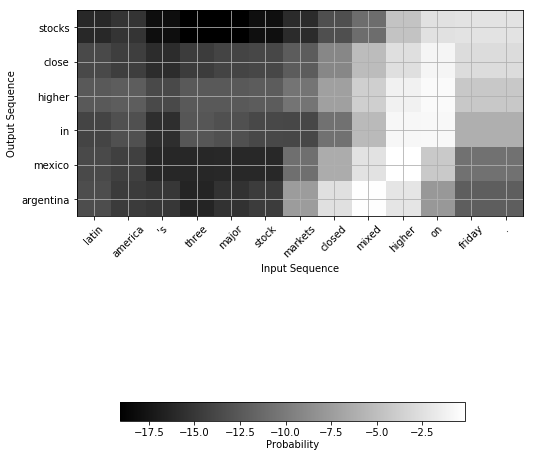

Sentence for prediction: latin america 's two of three major stock markets closed lower on monday .

Actual Summary: stocks close lower in mexico brazil

Predicted Summary: stocks close lower in mexico


<Figure size 432x288 with 0 Axes>

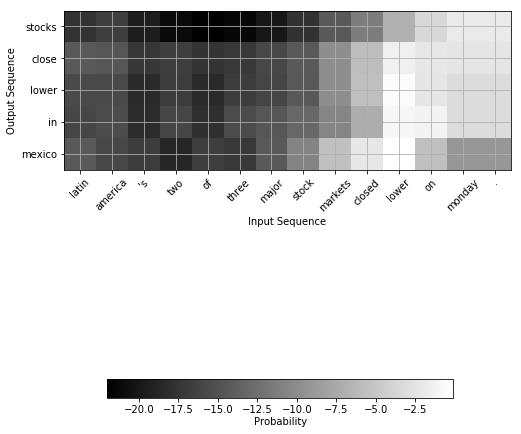

Sentence for prediction: australian prime minister john howard hopes to visit indonesia this year .

Actual Summary: australian prime minister to visit indonesia

Predicted Summary: australian prime minister to visit


<Figure size 432x288 with 0 Axes>

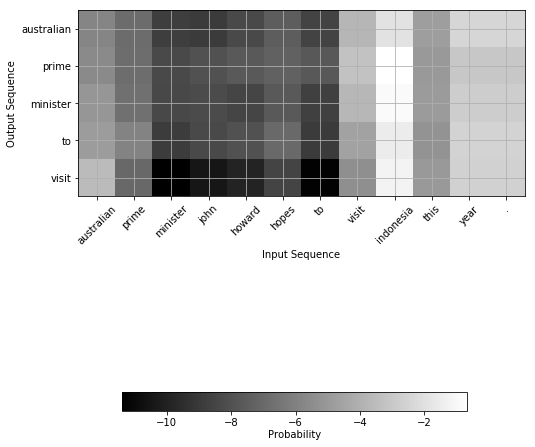

Sentence for prediction: tokyo stocks rose early thursday after an overnight rally on wall street .

Actual Summary: tokyo stocks rise dollar lower against yen in early trading

Predicted Summary: tokyo stocks rise dollar lower against yen in early trading


<Figure size 432x288 with 0 Axes>

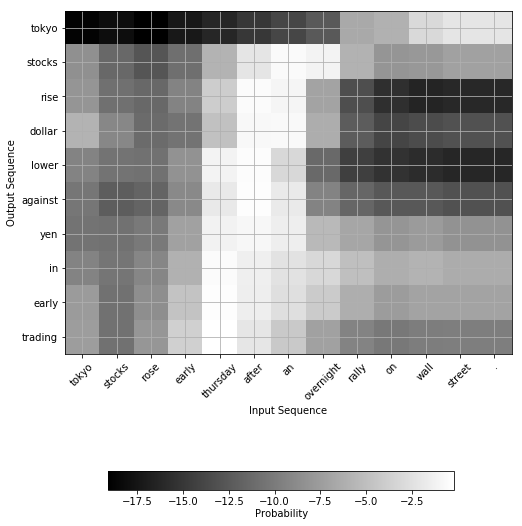

Sentence for prediction: rubber futures closed weaker wednesday on reduced volumes , dealers said .

Actual Summary: rubber futures close lower on smaller volumes

Predicted Summary: rubber futures close lower on smaller volumes


<Figure size 432x288 with 0 Axes>

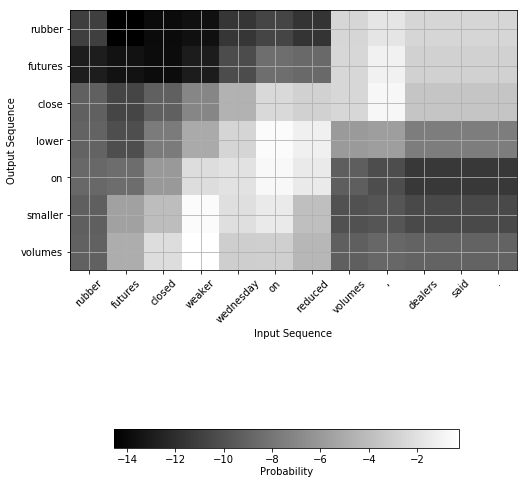

Sentence for prediction: managing in major league baseball 's all-star game is more than an honor .

Actual Summary: managers face difficult decisions picking all-star rosters

Predicted Summary: no has all all all in to


<Figure size 432x288 with 0 Axes>

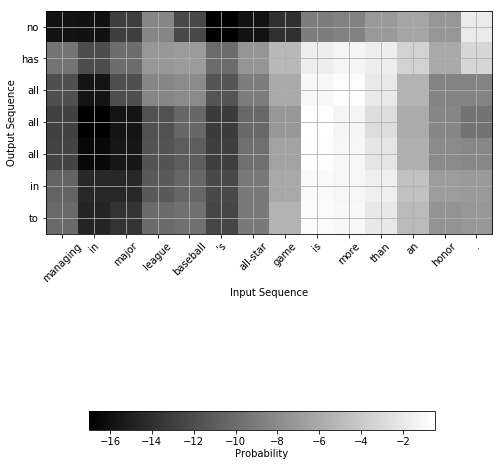

Sentence for prediction: there are some weeks when i am struck mightily by life 's little ironies .

Actual Summary: thoughts on life 's ironies old crooners and batman

Predicted Summary: unk makes a the unk


<Figure size 432x288 with 0 Axes>

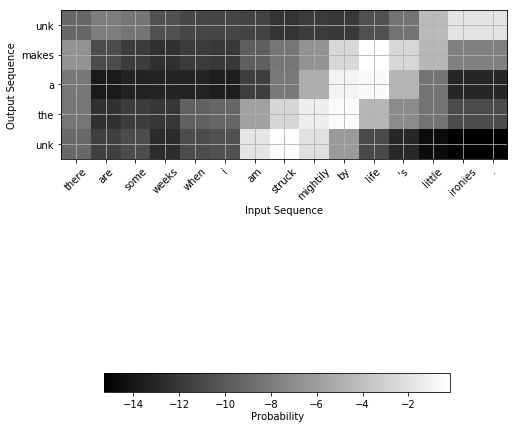

Sentence for prediction: john godina 's best throw fell # inches short of his goal saturday night .

Actual Summary: godina wins but misses on mark at l.a. invitational

Predicted Summary: unk unk unk unk


<Figure size 432x288 with 0 Axes>

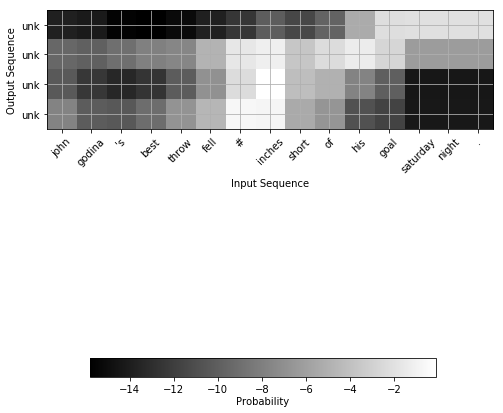

Sentence for prediction: no , i ca n't explain what happened last week at the arizona legislature .

Actual Summary: legislature 's reform bill held for revisions

Predicted Summary: a unk his a unk unk unk the


<Figure size 432x288 with 0 Axes>

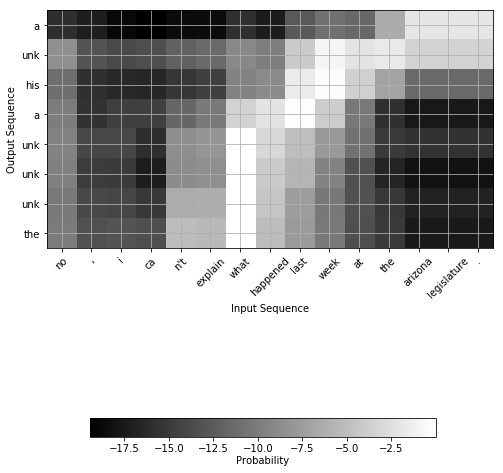

Sentence for prediction: the founder of cape cod potato chip co. cashed in his chips back in ' ## .

Actual Summary: potato chip entrepreneur wants his company back

Predicted Summary: unk founder unk unk unk unk juventus juventus unk


<Figure size 432x288 with 0 Axes>

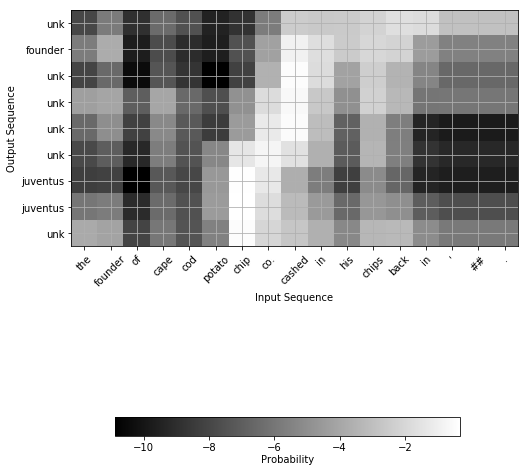

Sentence for prediction: by most measures , these should be salad days for economic policy makers .

Actual Summary: dollar decline may jeopardize moderating economic growth

Predicted Summary: some unk that about show show to to


<Figure size 432x288 with 0 Axes>

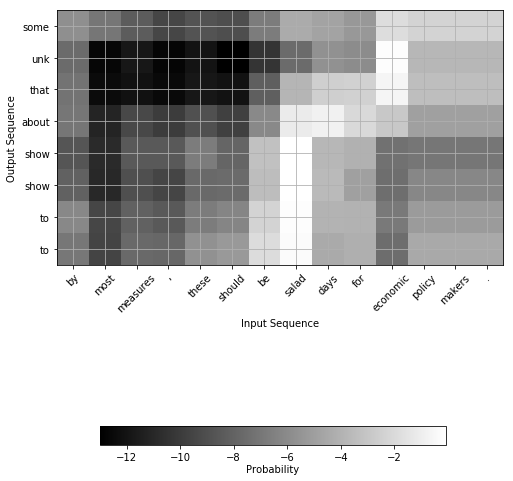

Sentence for prediction: crude prices jumped on wednesday as u.s. crude inventories fell last week .

Actual Summary: crude prices jump on u.s. inventories

Predicted Summary: crude prices surge on u u u u


<Figure size 432x288 with 0 Axes>

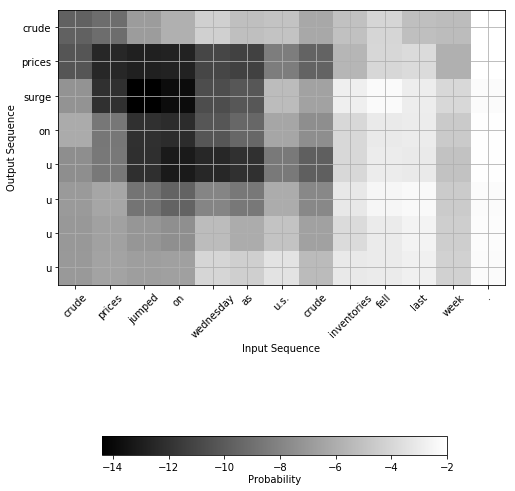

Sentence for prediction: geraldo rivera is no longer at large -- at least in the broadcast world .

Actual Summary: geraldo rivera s newsmagazine is canceled after a little more than a year

Predicted Summary: unk unk to the the on on on unk


<Figure size 432x288 with 0 Axes>

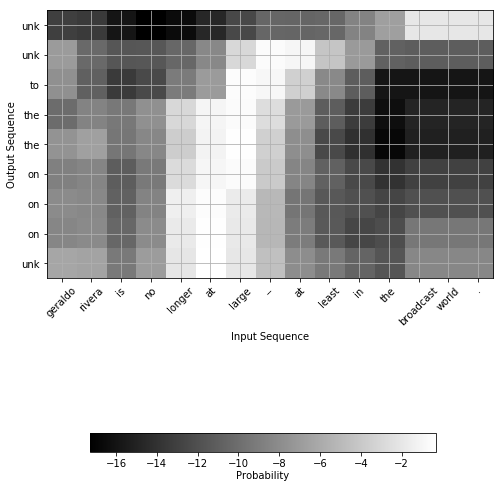

Sentence for prediction: warren buffett and alan greenspan say the housing market is near bottom .

Actual Summary: many obstacles to housing recovery

Predicted Summary: us unk unk of of in in


<Figure size 432x288 with 0 Axes>

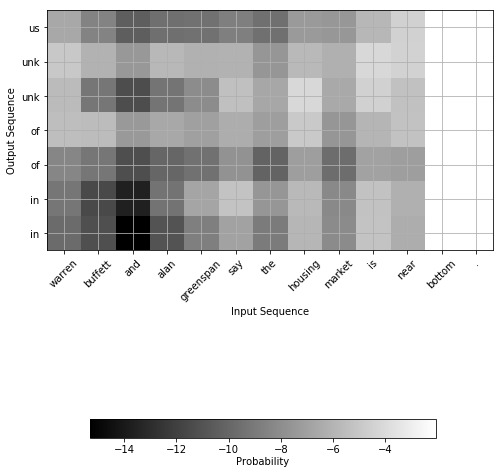

Sentence for prediction: brett lindros learned that concussions are n't like other sports injuries .

Actual Summary: nhl players get tests to help measure recovery from concussions

Predicted Summary: colorado rules return return


<Figure size 432x288 with 0 Axes>

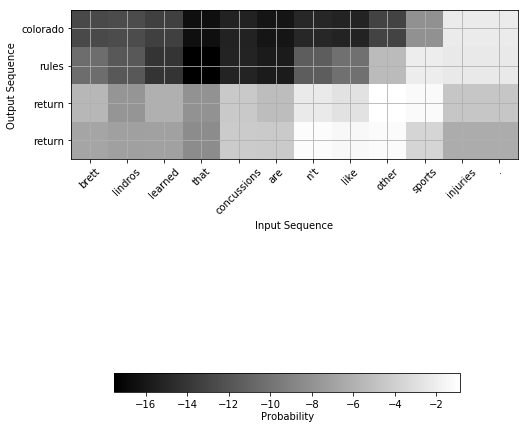

In [51]:
for i in selected:
    
    Print_Analysis(i)

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

![title](sentence.png)

From the sentences with better performances, I have identified that for both LSTM and LSTM with attention the model both perform abstraction tasks to a certain degree. For example, 'reduced volume' in 1923 paraphrased into 'smaller volume'. One other very interesting example is the mention of the change in foreign exchange rate between dollar and yen when the article merely talked about Tokyo stocks. All of these sentences did not capture the past tense in the article. For sentence 4099 for both models, destination proper nouns 'Indonesia' was dropped from the predictions. LSTM mistaken 'German' as 'Australian,' however did not fail to identify both terms are derivatives of country names. LSTM model was able to paraphrase visit to leave for. I selected 4141 and 4112 to compare them side-by-side. The two examples are similar. However, LSTM captured the number of terms correctly even though the output for 4141 is repetitive. Attention again has the problem of dropping last proper noun. I believe this is something to work on in the future. Finding out why the proper noun at the end is missing.

The five sentences with worse performances have a common issue of predicting unknowns and dropping words, which is predicting too many zeros. However, I think some of the results are still very interesting. For example, LSTM model using sentence 3499 predicted Elway, a football player when given MLB in the article. LSTM with attention predicted Juventus an Italian football club when the article is focusing on a potato chips company. One of the issues, may be causing the bad performances is comparing with the good examples, the gold standard is less similar to the original sentence, and some are completely different in semantic. 

In the randomly generated case, the same issue mentioned above also cause poor performances. For example, sentence 2069's article and title are entirely different, and both models gave meaningless results in this case. The same is true for 197 with only one common subject. LSTM model of 870 turned up some unusual abstractive summarization, even though the predictions are wrong and title not being a summary of the article. Warren Buffett and Greenspan can associate with Wal-Mart and Dow Jones Industrial, or just Dow.  One other interesting paraphrasing is changing jump in 6562 to surge in the LSTM with attention model. The model, however, failed to predict us. One of the disadvantages of removing punctuations is that model would treat abbreviates as individual letters. 6033 presented the problem that both models did poorly when an article and its title are different in meaning. LSTM, in this case, handled proper noun correctly. 


Good examples 1923 and 2817 presented two beautifully aligned weight maps with a white diagonal line. For example, 'closed' and 'weaker' have a high probability of having 'small' and 'volume', The result, in this case, seems to show that the model is predicting words with the highest correlation. Many function words such as 'is', 'a', 'are', 'on', period have correlation with most of the word. Not particularly surprised by the result. From the weight maps, I believe the model is functioning to a certain degree. 

Some of the error I have identified above shows that the LSTM attention model has the following problems, dropping proper noun. LSTM model has problems such as repetitive common words such as ''s', 'a', 'on', and proper noun. LSTM predicted sentence are more similar within a sentence vs LSTM with attention.  One attempt I would like to do is to include the POS tagging in the traning data so that the model would better differentiate words. As for LSTM with attention, I think the problem is probably easier to fix if punctuations are included. 

# Unidirectional LSTM Encoder Decoder With Attention and Beam Search (Extra Credit)

The models that you implemented till now had greedy decoder. Now implement a Decoder with Beam Search and show improved results